In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')
plt.rc('font', family='Times New Roman', size=7.5, weight='bold')
font = {'family': 'Times New Roman', 'weight': 'bold', 'size': 7.5}

In [2]:
# 摩尔质量
atom_mass = {'Ni': 58.69, 'Al': 26.98, 'Co': 58.93, 'Cr': 52, 'Mo': 95.95, 'Re': 186.2, 'Ru': 101.07,
             'Ti': 47.87, 'Ta': 180.94, 'W':  183.84, 'Hf': 178.49, 'Nb': 92.90, 'Si': 28.085, 'C': 12,
             'Y': 88.90, 'Ce': 140.12, 'B': 10.81}
# 内聚能
CE = {'Ni':4.435, 'Al':3.389, 'Co':4.394, 'Cr':4.094, 'Mo':6.819, 'Re':8.03, 'Ru':6.74, 'Ti':4.85, 'Ta':8.105, 
      'W':8.903, 'Hf':6.436, 'Nb':7.566, 'Si':4.63, 'C':7.37, 'Y':4.37, 'Ce':4.32, 'B':5.77}
# 电负性
PE = {'Ni':1.91, 'Al':1.61, 'Co':1.88, 'Cr':1.66, 'Mo':2.16, 'Re':1.9, 'Ru':2.2, 'Ti':1.54, 'Ta':1.5, 
      'W':2.36, 'Hf':1.3, 'Nb':1.6, 'Si':1.9, 'C':2.55, 'Y':1.22, 'Ce':1.12, 'B':2.04}
# 电离能
IE = {'Ni':737.1, 'Al':577.5, 'Co':760.4, 'Cr':652.9, 'Mo':684.3, 'Re':760, 'Ru':710.2, 'Ti':658.8, 'Ta':761, 
      'W':770, 'Hf':658.5, 'Nb':652.1, 'Si':786.5, 'C':1086.5, 'Y':600, 'Ce':534.4, 'B':800.6}
# 空位形成能
VE = {'Ni':1.41, 'Al':0.76, 'Co':1.25, 'Cr':1.8, 'Mo':2.67, 'Re':2.37, 'Ru':1.91, 'Ti':1.56, 'Ta':2.88, 
      'W':3.22, 'Hf':1.87, 'Nb':2.4, 'Si':0, 'C':0, 'Y':1.19, 'Ce':1.27, 'B':0}
# 原子半径
atom_radius = {'Ni': 0.149, 'Al': 0.118, 'Co': 0.152, 'Cr': 0.166, 'Mo': 0.19, 'Re': 0.188, 'Ru': 0.178, 'Ti': 0.176,
               'Ta': 0.2, 'W': 0.193, 'Hf': 0.208, 'Nb': 0.198,
               'Si': 0.111, 'C': 0.067, 'Y': 0.212, 'Ce': 0.185, 'B': 0.087}
# 离子半径
ion_radius = {'Ni': 72, 'Al': 50, 'Co': 74, 'Cr': 69, 'Mo': 62, 'Re': 63, 'Ru': 81, 'Ti': 68,
              'Ta': 69, 'W': 62, 'Hf': 79, 'Nb': 70, 'Si': 42, 'C': 16, 'Y': 90, 'Ce': 92, 'B': 20}
# 元素价态
ion_valence = {'Ni': 2, 'Al': 3, 'Co': 3, 'Cr': 3, 'Mo': 6, 'Re': 5, 'Ru': 4, 'Ti': 4, 'Ta': 5, 'W': 6, 
               'Hf':4, 'Nb':5, 'Si':4, 'C':4, 'Y':3, 'Ce':4, 'B':3}
# e/a
e_a_con = {'Ni': 1.16, 'Al': 3.01, 'Co': 1.03, 'Cr': 0.92, 'Mo': 1.39, 'Re': 1.4, 'Ru': 1.04, 'Ti': 1.14,
           'Ta': 1.57, 'W': 1.43, 'Hf':1.76, 'Nb':1.32, 'Si':4, 'C':3.92, 'Y':3.15, 'B':2.98}
# Ni中扩散系数
D0_Ni = {'Ni':1.9e-4, 'Al': 1.85e-4, 'Co':7.5e-5, 'Cr':3e-6, 'Mo':1.15e-4, 'Re':8.2e-7, 
         'Ru':2.48e-4, 'Ti':4.1e-4, 'Ta':0.031e-4, 'W':8e-6, 'Nb': 0.595e-4}
# Ni中扩散激活能
q_Ni = {'Ni': -287, 'Al': -284, 'Co': -284.169, 'Cr': -287, 'Mo': -267.585, 'Re': -278.817,
        'Ru': -304.489, 'Ti': -256.9, 'Ta': -267.729, 'W': -282.13, 'Hf': -251.956, 'Nb': -230}
# Ni3Al中扩散系数
D0_Ni3Al = {'Ni':1e-4, 'Al': 6.6e-8, 'Co':4.2e-3, 'Cr':1.1e-1, 'Mo':2.3e2, 'Re':1.5, 
            'Ru':1.3e-3, 'Ti':56, 'Ta':7.16, 'Nb': 26}
# Ni3Al中扩散激活能
q_Ni3Al = {'Ni': -303, 'Al': -258, 'Co': -325, 'Cr': -366, 'Mo': -493,
           'Re': -467.5, 'Ru': -318.7, 'Ti': -468, 'Ta': -425, 'Nb': -475.6}

In [3]:
class FeatureEngineer:
    def __init__(self, properties_dict, data):
        self.properties_dict = properties_dict
        self.data = data

    def mean_calc(self, p_dict):
        calc_num = np.zeros(len(self.data))
        for atom in p_dict.keys():
            calc_num += self.data.loc[:, atom].values * p_dict[atom]
        return calc_num

    def diff_calc(self, p_dict):
        calc_num = np.zeros(len(self.data))
        for atom in p_dict.keys():
            calc_num += self.data[atom].values * (p_dict['Ni'] - p_dict[atom]) ** 2
        return np.sqrt(calc_num)

    def get_feature(self):
        feature_df = pd.DataFrame()
        for p_name, p_dict in self.properties_dict.items():
            feature_df[p_name + '_avg'] = self.mean_calc(p_dict)
            feature_df[p_name + '_var'] = self.diff_calc(p_dict)
        return feature_df

In [4]:
def wt_to_at(data, atom_features):
    wt_value = data[atom_features].values
    at_value = wt_value / np.array([atom_mass[j] for j in atom_features])
    sum_num = np.sum(at_value, axis=1).reshape(-1, 1)
    at_value = at_value / sum_num
    for index, i in enumerate(atom_features):
        data.loc[:, i] = at_value[:, index]
    return data

def G_al2o3(T, al_a):
    G0 = 0.2193*(T + 273.15) - 1127.3137
    R = 8.314
    p = 0.2
    return G0 + (R*(T + 273.15)*np.log(1 / al_a**(4/3) / p)) / 1000

def Val_eff(data, c=False):
    val_eff_num = 0
    for i in ion_valence.keys():
        if not c:
            val_eff_num += (ion_valence[i] - 3)*data[i]
        elif c == 'A1':
            if i in ['Ni', 'Al', 'Co', 'Cr', 'Mo', 'Re', 'Ru', 'Ti', 'Ta', 'W', 'Hf']: 
                val_eff_num += (ion_valence[i] - 3)*data[i + '_A1']
        elif c == 'L12':
            if i in ['Ni', 'Al', 'Co', 'Cr', 'Mo', 'Re', 'Ru', 'Ti', 'Ta', 'W', 'Hf']: 
                val_eff_num += (ion_valence[i] - 3)*data[i + '_L12']
    return val_eff_num

def Ni_diffusion(data):
    D0_eff = 0
    elem = ['Ni', 'Al', 'Co', 'Cr', 'Mo', 'Re', 'Ru', 'Ti', 'Ta', 'W']
    for atom in elem:
        D0_eff += D0_Ni[atom] * data[atom + '_A1']
    Q_eff = q_Ni['Ni']
    for atom in elem[1: ]:
        Q_eff += q_Ni[atom] * data[atom + '_A1']
    D_eff = D0_eff*np.exp(Q_eff*1000 / 8.314 / (data['Temperature'] + 273.15))
    return D_eff

def Ni3Al_diffusion(data):
    D0_eff = 0
    elem = ['Ni', 'Al', 'Co', 'Cr', 'Mo', 'Re', 'Ru', 'Ti', 'Ta']
    for atom in elem:
        D0_eff += D0_Ni3Al[atom] * data[atom + '_L12']
    Q_eff = 0
    for atom in elem:
        Q_eff += q_Ni3Al[atom] * data[atom + '_L12']
    D_eff = D0_eff*np.exp(Q_eff*1000 / 8.314 / (data['Temperature'] + 273.15))
    return D_eff

In [5]:
def computeCorrelation(X, Y):
    xBar = np.mean(X)
    yBar = np.mean(Y)
    SSR = 0
    varX = 0
    varY = 0
    for i in range(0 , len(X)):
        diffXXBar = X[i] - xBar
        diffYYBar = Y[i] - yBar
        SSR += (diffXXBar * diffYYBar)
        varX +=  diffXXBar**2
        varY += diffYYBar**2
    
    SST = np.sqrt(varX * varY)
    return SSR / SST

In [6]:
path = 'C:/Users/chonglh/Desktop/oxidaton2.0/data/Al2O3_tc_data2.0.csv'
sign_path = 'D:/Oxidation Data/氧化原始数据/Al2O3_tc_data_label.csv'
composition_features = ['Ni', 'Al', 'Co', 'Cr', 'Mo', 'Re', 'Ru', 'Ti', 'Ta', 'W', 'Hf', 'Nb', 'Si', 'C', 'Y', 'Ce', 'B']
a_features = ['Ni_a', 'Al_a', 'Co_a', 'Cr_a']
properties_dict = {'CE': CE, 'PE': PE, 'IE': IE, 'VE': VE, 'a_r': atom_radius, 'i_r': ion_radius,
                   'ion_v': ion_valence, 'e_a_con': e_a_con}

In [7]:
data = pd.read_csv(path, encoding='gb2312')
# transfer wt. to at.
data = wt_to_at(data, composition_features)
# cbcv features
FE = FeatureEngineer(properties_dict, data)
cbfv_features = FE.get_feature()
for i in cbfv_features.columns:
    data[i] = cbfv_features[i]
sign_data = pd.read_csv(sign_path, encoding='gb2312')
continuous = sign_data['Continuous Al2O3?']
data['continuous'] = continuous
data = data[data['continuous'] == '1']
data['index'] = range(len(data))
data['group'] = data.groupby(composition_features)['index'].transform('max')
groups = data['group']
data.drop(['index', 'group', 'continuous'], axis=1, inplace=True)

In [8]:
composition_num = len(set(groups))
kp_label = np.log(data['k(g2/m4/h)'].values)
gkf = GroupKFold(n_splits=composition_num)

In [9]:
# domain features
data['Val_eff_c'] = Val_eff(data)
data['Val_eff_γ'] = Val_eff(data, c='A1')
data["Val_eff_γ'"] = Val_eff(data, c='L12')
data['G_al2O3'] = G_al2o3(data['Temperature'], data['Al_a'])
data['D_Ni'] = Ni_diffusion(data)
data['D_Ni3Al'] = Ni3Al_diffusion(data)

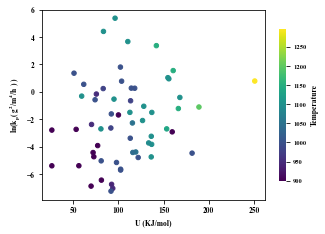

In [10]:
U_data = data['G_al2O3'].values * data['Val_eff_γ'].values
plt.figure(figsize=(5, 3.5))
plt.scatter(U_data, kp_label, c=data['Temperature'], s=20)
plt.xlabel('U (KJ/mol)', font)
plt.ylabel('ln($\mathregular{k_p}$( $\mathregular{g^2}$/$\mathregular{m^4}$/h ) )', font)
cb = plt.colorbar(alpha=0.85, shrink=0.8, ticks=None, aspect=21)
cb.outline.set_visible(False)
cb.set_label('Temperature', fontdict={'family': 'Times New Roman', 'weight': 'bold', 'size': 7.5})
cb.ax.tick_params(labelsize=6.5) 
# plt.savefig('C:/Users/chonglh/Desktop/oxidaton2.0/result/Wagner/U.tif', dpi=330, bbox_inches='tight')
plt.show()

In [11]:
U1 = np.array([26.67963, 160.65541, 155.66118, 154.79262, 56.64504, 73.36487, 72.11631, 77.16483, 115.43587, 126.56433, 
               136.98708, 128.19288, 53.27936, 70.21633, 92.6361, 80.69336, 91.76754, 100.39888, 112.50447, 113.53589, 118.36727, 114.18731])
kp_label1 = np.array([-5.38792, 1.55681, 0.96247, 1.05973, -5.37351, -4.73235, -4.44058, -3.91469, -2.29017, -2.06684, -1.49772, 
                      -1.05467, -2.73322, -2.38742, -1.59497, -2.71881, -2.65037, -1.67782, -1.49772, -0.66565, 0.28169, 0.28169])

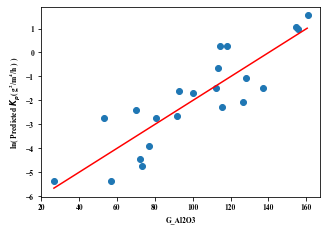

In [12]:
linear = LinearRegression(fit_intercept=True)
linear.fit(U1.reshape(-1, 1), kp_label1)
x = np.arange(np.min(U1), np.max(U1), 0.2)
y = linear.predict(x.reshape(-1, 1))
plt.figure(figsize=(5, 3.5))
plt.scatter(U1, kp_label1)
plt.plot(x, y, c='red')
plt.xlabel('G_Al2O3', font)
plt.ylabel('ln( Predicted $K_{p}$( $\mathregular{g^2}$/$\mathregular{m^4}$/h ) )', font)
# plt.savefig('C:/Users/chonglh/Desktop/linear.tif', dpi=330, bbox_inches='tight')
plt.show()

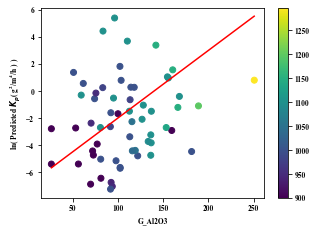

In [13]:
x = np.arange(np.min(U_data), np.max(U_data), 0.2)
y = linear.predict(x.reshape(-1, 1))
plt.figure(figsize=(5, 3.5))
plt.scatter(U_data, kp_label, c=data['Temperature'])
plt.plot(x, y, c='red')
plt.xlabel('G_Al2O3', font)
plt.ylabel('ln( Predicted $K_{p}$( $\mathregular{g^2}$/$\mathregular{m^4}$/h ) )', font)
plt.colorbar()
# plt.savefig('C:/Users/chonglh/Desktop/linear.tif', dpi=330, bbox_inches='tight')
plt.show()

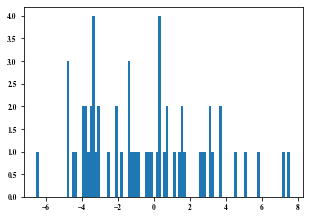

In [14]:
linear1_pre = linear.predict(U_data.reshape(-1, 1))
res = kp_label - linear1_pre
plt.figure(figsize=(5, 3.5))
plt.hist(res, bins=100)
plt.show()

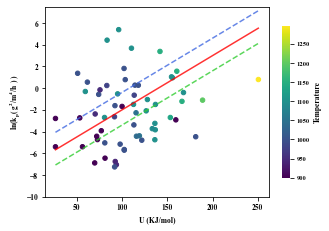

In [15]:
x = np.arange(np.min(U_data), np.max(U_data), 0.2)
y = linear.predict(x.reshape(-1, 1))
plt.figure(figsize=(5, 3.5))
plt.scatter(U_data, kp_label, c=data['Temperature'], s=20)
plt.xlabel('U (KJ/mol)', font)
plt.ylabel('ln($\mathregular{k_p}$( $\mathregular{g^2}$/$\mathregular{m^4}$/h ) )', font)
cb = plt.colorbar(alpha=0.85, shrink=0.8, ticks=None, aspect=21)
cb.outline.set_visible(False)
cb.set_label('Temperature', fontdict={'family': 'Times New Roman', 'weight': 'bold', 'size': 7.5})
cb.ax.tick_params(labelsize=6.5) 
plt.plot(x, y, c='red', alpha=0.8)
plt.plot(x, y + 1.6049, '--', c='royalblue', linewidth=1.5, alpha=0.8)
plt.plot(x, y - 1.4, '--', c='limegreen', linewidth=1.5, alpha=0.8)
plt.ylim(-10, 7.5)
# plt.savefig('C:/Users/chonglh/Desktop/U-kp.tif', dpi=330, bbox_inches='tight')
plt.show()

In [16]:
U_df = pd.DataFrame()
U_df['Temperature'] = data['Temperature']
U_df['U'] = U_data
U_df['kp_label'] = kp_label
U_df['linear_pre'] = linear1_pre
U_df['res'] = res

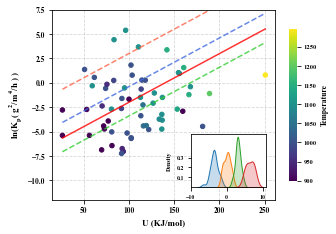

In [17]:
x = np.arange(np.min(U_data), np.max(U_data), 0.2)
y = linear.predict(x.reshape(-1, 1))
plt.figure(figsize=(5, 3.5))
plt.grid(linestyle='--', alpha=0.5, zorder=0)
plt.plot(x, y, c='red', alpha=0.8)
plt.plot(x, y + 5, '--', c='tomato', linewidth=1.5, alpha=0.8)
plt.plot(x, y + 1.6049, '--', c='royalblue', linewidth=1.5, alpha=0.8)
plt.plot(x, y - 1.4, '--', c='limegreen', linewidth=1.5, alpha=0.8)
plt.scatter(U_data, kp_label, c=data['Temperature'], s=20, zorder=2)
plt.xlabel('U (KJ/mol)', {'family': 'Times New Roman', 'weight': 'bold', 'size': 9})
plt.ylabel('ln($\mathregular{K_p}$( $\mathregular{g^2}$/$\mathregular{m^4}$/h ) )', {'family': 'Times New Roman', 'weight': 'bold', 'size': 9})
cb = plt.colorbar(alpha=0.85, shrink=0.8, ticks=None, aspect=21)
cb.outline.set_visible(False)
cb.set_label('Temperature', fontdict={'family': 'Times New Roman', 'weight': 'bold', 'size': 7.5})
cb.ax.tick_params(labelsize=6.5) 
plt.ylim(-12, 7.5)
plt.axes([0.51, 0.175, 0.21, 0.21])
sns.kdeplot(x=U_df[U_df['res'] <= -1.3968]['res'].values, fill=True)
sns.kdeplot(x=U_df[(U_df['res'] > -1.3968)&(U_df['res'] < 1.6049)]['res'].values, fill=True)
sns.kdeplot(x=U_df[(U_df['res'] >= 1.6049)&(U_df['res'] < 5)]['res'].values, fill=True)
sns.kdeplot(x=U_df[(U_df['res'] >= 5)]['res'].values, fill=True)
plt.ylabel('Density', fontdict={'family': 'times new roman', 'size': 6, 'weight': 'bold'})
plt.xticks([-10, 0, 10], font={'family': 'times new roman', 'size': 6, 'weight': 'bold'})
plt.yticks([0.1, 0.2, 0.3], font={'family': 'times new roman', 'size': 6, 'weight': 'bold'})
# plt.savefig('C:/Users/chonglh/Desktop/U-kp.tif', dpi=330, bbox_inches='tight')
plt.show()

In [18]:
U_data_low = U_df[U_df['res'] < -1.3968]
U_data_mid = U_df[(U_df['res'] >= -1.3968)&(U_df['res'] <= 1.6049)]
U_data_up = U_df[(U_df['res'] > 1.6049)&(U_df['res'] < 5)]
U_data_up2 = U_df[(U_df['res'] >= 5)]

In [19]:
from sklearn.svm import SVR

0.7420320882704082
0.8906781513152557
0.890231566407782
0.8629900410230322


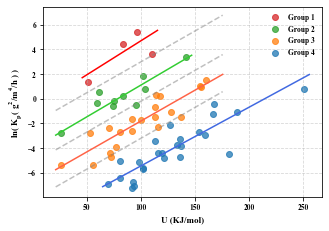

In [20]:
# outlier high
linear1 = SVR(kernel='linear', C=0.003)
linear1.fit(U_data_up2['U'].values.reshape(-1, 1), U_data_up2['kp_label'].values)
x = np.arange(np.min(U_data_up2['U'].values) - 5, np.max(U_data_up2['U'].values) + 5, 0.2)
y = linear1.predict(x.reshape(-1, 1))
plt.figure(figsize=(5, 3.5))
plt.grid(linestyle='--', alpha=0.5, zorder=0)
plt.scatter(U_data_up2['U'].values, U_data_up2['kp_label'].values, 
            label='Group 1', alpha=0.75, c='tab:red')
plt.plot(x, y, c='red')
print(computeCorrelation(U_data_up2['kp_label'].values, linear1.predict(U_data_up2['U'].values.reshape(-1, 1))))
# high
linear2 = SVR(kernel='linear')
linear2.fit(U_data_up['U'].values.reshape(-1, 1), U_data_up['kp_label'].values)
x = np.arange(np.min(U_data_up['U'].values) - 5, np.max(U_data_up['U'].values) + 5, 0.2)
y = linear2.predict(x.reshape(-1, 1))
plt.scatter(U_data_up['U'].values, U_data_up['kp_label'].values, 
            label='Group 2', alpha=0.75, c='tab:green')
plt.plot(x, y, c='limegreen')
print(computeCorrelation(U_data_up['kp_label'].values, linear1.predict(U_data_up['U'].values.reshape(-1, 1))))
# mid
linear3 = SVR(kernel='linear')
linear3.fit(U_data_mid['U'].values.reshape(-1, 1), U_data_mid['kp_label'].values)
x = np.arange(np.min(U_data_mid['U'].values ) - 5, np.max(U_data_mid['U'].values) + 15, 0.2)
y = linear3.predict(x.reshape(-1, 1))
plt.plot(x, y + 4.8, '--', c='gray', alpha=0.5)
plt.plot(x, y + 1.6049, '--', c='gray', alpha=0.5)
plt.plot(x, y - 1.4, '--', c='gray', alpha=0.5)
plt.scatter(U_data_mid['U'].values, U_data_mid['kp_label'].values, 
            label='Group 3', alpha=0.75, c='tab:orange')
plt.plot(x, y, c='tomato')
print(computeCorrelation(U_data_mid['kp_label'].values, linear1.predict(U_data_mid['U'].values.reshape(-1, 1))))
# low
linear4 = SVR(kernel='linear')
linear4.fit(U_data_low['U'].values.reshape(-1, 1), U_data_low['kp_label'].values)
x = np.arange(np.min(U_data_low['U'].values) - 5, np.max(U_data_low['U'].values) + 5, 0.2)
y = linear4.predict(x.reshape(-1, 1))
plt.scatter(U_data_low['U'].values, U_data_low['kp_label'].values, 
            label='Group 4', alpha=0.75, c='tab:blue')
plt.plot(x, y, c='royalblue')
print(computeCorrelation(U_data_low['kp_label'].values, linear1.predict(U_data_low['U'].values.reshape(-1, 1))))
plt.xlabel('U (KJ/mol)', {'family': 'Times New Roman', 'weight': 'bold', 'size': 9})
plt.ylabel('ln( $\mathregular{K_p}$( $\mathregular{g^2}$/$\mathregular{m^4}$/h ) )', {'family': 'Times New Roman', 'weight': 'bold', 'size': 9})
# plt.colorbar()
plt.legend(frameon=False)
# plt.savefig('C:/Users/chonglh/Desktop/Group.tif', dpi=330, bbox_inches='tight')
plt.show()

In [21]:
print('Group 1 coef {:.3f} intercept {:.3f}'.format(linear1.coef_[0][0], linear1.intercept_[0]))
print('Group 2 coef {:.3f} intercept {:.3f}'.format(linear2.coef_[0][0], linear2.intercept_[0]))
print('Group 3 coef {:.3f} intercept {:.3f}'.format(linear3.coef_[0][0], linear3.intercept_[0]))
print('Group 4 coef {:.3f} intercept {:.3f}'.format(linear4.coef_[0][0], linear4.intercept_[0]))

Group 1 coef 0.055 intercept -0.835
Group 2 coef 0.052 intercept -4.064
Group 3 coef 0.050 intercept -6.832
Group 4 coef 0.048 intercept -10.223


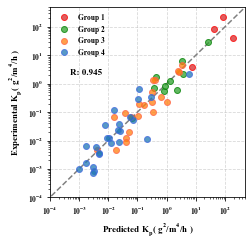

0.9667228376195532
0.7410149904475293
0.9449101649160587
0.8920657248046348


In [22]:
# low
plt.figure(figsize=(3.5, 3.5))
plt.grid(linestyle='--', alpha=0.5, zorder=0)
plt.plot(range(-1, 21000, 1), range(-1, 21000, 1), '--', c='gray')
# outliter high
linear1 = SVR(kernel='linear', C=0.003)
linear1.fit(U_data_up2['U'].values.reshape(-1, 1), U_data_up2['kp_label'].values)
y4 = linear1.predict(U_data_up2['U'].values.reshape(-1, 1))
plt.loglog(np.exp(y4), np.exp(U_data_up2['kp_label'].values), '.', marker='o',
           c='tab:red', markeredgecolor='red', label='Group 1', zorder=2, alpha=0.75)
# plt.scatter(y4, U_data_up2['kp_label'].values)

# high
linear2 = SVR(kernel='linear')
linear2.fit(U_data_up['U'].values.reshape(-1, 1), U_data_up['kp_label'].values)
y2 = linear2.predict(U_data_up['U'].values.reshape(-1, 1))
plt.loglog(np.exp(y2), np.exp(U_data_up['kp_label'].values), '.', marker='o',
           c='tab:green', markeredgecolor='green', label='Group 2', zorder=2, alpha=0.75)
# plt.scatter(y2, U_data_up['kp_label'].values)

# mid
linear3 = SVR(kernel='linear')
linear3.fit(U_data_mid['U'].values.reshape(-1, 1), U_data_mid['kp_label'].values)
y3 = linear3.predict(U_data_mid['U'].values.reshape(-1, 1))
plt.loglog(np.exp(y3), np.exp(U_data_mid['kp_label'].values), '.', marker='o',
           c='tab:orange', markeredgecolor='tomato', label='Group 3', zorder=2, alpha=0.75)
# plt.scatter(y3, U_data_mid['kp_label'].values)
linear4 = SVR(kernel='linear')
linear4.fit(U_data_low['U'].values.reshape(-1, 1), U_data_low['kp_label'].values)
y1 = linear4.predict(U_data_low['U'].values.reshape(-1, 1))
plt.loglog(np.exp(y1), np.exp(U_data_low['kp_label'].values), '.', marker='o',
           c='tab:blue', markeredgecolor='royalblue', label='Group 4', zorder=2, alpha=0.75)
# plt.scatter(y1, U_data_low['kp_label'].values)
a = [y1, y2, y3, y4]
b = [U_data_low['kp_label'].values, U_data_up['kp_label'].values, U_data_mid['kp_label'].values, U_data_up2['kp_label'].values]
plt.xlim(10**(-4), 500)
plt.ylim(10**(-4), 500)
plt.xlabel('Predicted $\mathregular{K_p}$( $\mathregular{g^2}$/$\mathregular{m^4}$/h )', {'family': 'Times New Roman', 'weight': 'bold', 'size': 9})
plt.ylabel('Experimental $\mathregular{K_p}$( $\mathregular{g^2}$/$\mathregular{m^4}$/h )', {'family': 'Times New Roman', 'weight': 'bold', 'size': 9})
plt.text(0.0005, 2, s='R: {:.3f}'.format(computeCorrelation(np.concatenate(a, axis=0), np.concatenate(b, axis=0))), fontdict={'family': 'Times New Roman', 'weight': 'bold', 'size': 9})
plt.legend(frameon=False)
# plt.savefig('C:/Users/chonglh/Desktop/Group_perfect.tif', dpi=330, bbox_inches='tight')
plt.show()
print(np.sqrt(mean_squared_error(np.concatenate(b, axis=0), np.concatenate(a, axis=0))))
print(mean_absolute_error(np.concatenate(b, axis=0), np.concatenate(a, axis=0)))
print(computeCorrelation(np.concatenate(b, axis=0), np.concatenate(a, axis=0)))
print(r2_score(np.concatenate(b, axis=0), np.concatenate(a, axis=0)))

In [23]:
linear_list0 = [linear1, linear2, linear3, linear4]

In [24]:
def c_label(x):
    if x < -1.3968:
        return 0 
    elif x>= -1.3968 and x <= 1.6049:
        return 2
    elif x > 1.6049 and x < 5:
        return 1
    elif x >= 5:
        return 3

In [25]:
classify_label = U_df['res'].map(c_label).values

In [26]:
data['classify_label'] = classify_label

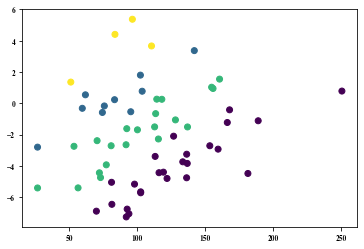

In [27]:
plt.scatter(U_df['U'], kp_label, c=classify_label)

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix

0.8166666666666667


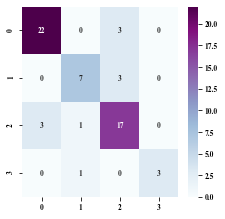

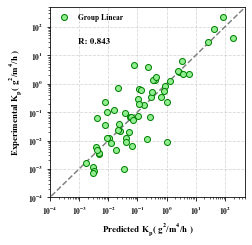

0.8429869484270367


In [29]:
f = ['VE_avg', 'e_a_con_avg', 'i_r_var', 'D_Ni3Al', 'CE_avg', 'PE_var', 'D_Ni', "Val_eff_γ'"]
data_f = data[f]
# classify
test_list = []
pre_list = []
# Regression
test_list1 = []
pre_list1 = []
for fold, (train_id, test_id) in enumerate(gkf.split(data_f, kp_label, groups=groups)):
    # train, test
    train = data_f.values[train_id]
    test = data_f.values[test_id]
    # Standar transform
    scalar = StandardScaler()
    train = scalar.fit_transform(train)
    test = scalar.transform(test)
    # classify label
    train_label = classify_label[train_id]
    test_label = classify_label[test_id]
    test_list.append(test_label)
    # Regression label
    train_label1 = kp_label[train_id]
    test_label1 = kp_label[test_id]
    test_list1.append(test_label1)
    # Classify
    rf = lgb.LGBMClassifier(**{'n_estimators': 1657, 'subsample': 0.832392,
                               'colsample_bytree': 0.91, 'reg_alpha': 0.0391247, 
          'reg_lambda': 1.6462272, 'min_child_samples': 2}, silent=False, verbosity=-1)
    rf.fit(train, train_label)
    train_pre = rf.predict(train)
    test_pre = rf.predict(test)
    pre_list.append(test_pre)
    # Linear Regression
    for i in range(len(test_pre)):
        if test_pre[i] == 0:
            test_pre1 = linear_list0[3].predict(U_df['U'].values[test_id][i].reshape(1, -1))
        elif test_pre[i] == 1:
            test_pre1 = linear_list0[1].predict(U_df['U'].values[test_id][i].reshape(1, -1))
        elif test_pre[i] == 2:
            test_pre1 = linear_list0[2].predict(U_df['U'].values[test_id][i].reshape(1, -1))
        else:
            test_pre1 = linear_list0[0].predict(U_df['U'].values[test_id][i].reshape(1, -1))
        pre_list1.append(test_pre1)

print(accuracy_score(np.concatenate(test_list, axis=0), np.concatenate(pre_list, axis=0)))
plt.figure(figsize=(3.5, 3.5))
sns.heatmap(confusion_matrix(np.concatenate(test_list, axis=0), np.concatenate(pre_list, axis=0)), annot=True, cmap="BuPu")
plt.show()

plt.figure(figsize=(3.5, 3.5))
plt.grid(linestyle='--', alpha=0.5, zorder=0)
plt.plot(range(0, 21000, 1), range(0, 21000, 1), '--', c='gray')
plt.loglog(np.exp(np.concatenate(pre_list1, axis=0)), np.exp(np.concatenate(test_list1, axis=0)), '.', 
            c='lightgreen', marker='o', label='Group Linear', markeredgecolor='green', zorder=2)
plt.xlim(10**(-4), 500)
plt.ylim(10**(-4), 500)
plt.xlabel('Predicted $\mathregular{K_p}$( $\mathregular{g^2}$/$\mathregular{m^4}$/h )', {'family': 'Times New Roman', 'weight': 'bold', 'size': 9})
plt.ylabel('Experimental $\mathregular{K_p}$( $\mathregular{g^2}$/$\mathregular{m^4}$/h )', {'family': 'Times New Roman', 'weight': 'bold', 'size': 9})
plt.text(0.0009, 25, s='R: {:.3f}'.format(computeCorrelation(np.concatenate(test_list1, axis=0), np.concatenate(pre_list1, axis=0))), fontdict={'family': 'Times New Roman', 'weight': 'bold', 'size': 9})
plt.legend(loc=2, frameon=False, labelspacing=2)
# plt.savefig('C:/Users/chonglh/Desktop/group_pre1.tif', dpi=330, bbox_inches='tight')
plt.show()
print(computeCorrelation(np.concatenate(test_list1, axis=0), np.concatenate(pre_list1, axis=0)))

0.8166666666666667


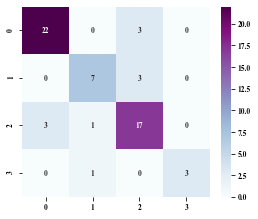

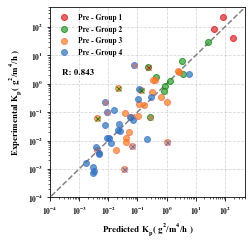

0.8429869484270367


In [30]:
f = ['VE_avg', 'e_a_con_avg', 'i_r_var', 'D_Ni3Al', 'CE_avg', 'PE_var', 'D_Ni', "Val_eff_γ'"]
data_f = data[f]
# classify
test_list = []
pre_list = []
# Regression
test_list1 = []
pre_list1 = []
for fold, (train_id, test_id) in enumerate(gkf.split(data_f, kp_label, groups=groups)):
    # train, test
    train = data_f.values[train_id]
    test = data_f.values[test_id]
    # Standar transform
    scalar = StandardScaler()
    train = scalar.fit_transform(train)
    test = scalar.transform(test)
    # classify label
    train_label = classify_label[train_id]
    test_label = classify_label[test_id]
    test_list.append(test_label)
    # Regression label
    train_label1 = kp_label[train_id]
    test_label1 = kp_label[test_id]
    test_list1.append(test_label1)
    # Classify
    rf = lgb.LGBMClassifier(**{'n_estimators': 1657, 'subsample': 0.832392,
                               'colsample_bytree': 0.91, 'reg_alpha': 0.0391247, 
          'reg_lambda': 1.6462272, 'min_child_samples': 2}, silent=False, verbosity=-1)
    rf.fit(train, train_label)
    train_pre = rf.predict(train)
    test_pre = rf.predict(test)
    pre_list.append(test_pre)
    # Linear Regression
    for i in range(len(test_pre)):
        if test_pre[i] == 0:
            test_pre1 = linear_list0[3].predict(U_df['U'].values[test_id][i].reshape(1, -1))
        elif test_pre[i] == 1:
            test_pre1 = linear_list0[1].predict(U_df['U'].values[test_id][i].reshape(1, -1))
        elif test_pre[i] == 2:
            test_pre1 = linear_list0[2].predict(U_df['U'].values[test_id][i].reshape(1, -1))
        else:
            test_pre1 = linear_list0[0].predict(U_df['U'].values[test_id][i].reshape(1, -1))
        pre_list1.append(test_pre1)

print(accuracy_score(np.concatenate(test_list, axis=0), np.concatenate(pre_list, axis=0)))
plt.figure(figsize=(4.2, 3.5))
sns.heatmap(confusion_matrix(np.concatenate(test_list, axis=0), np.concatenate(pre_list, axis=0)), annot=True, cmap="BuPu")
# plt.savefig('C:/Users/chonglh/Desktop/classify_res.tif', dpi=330, bbox_inches='tight')
plt.show()

def get_group_id(label):
    id_list = []
    for i in range(len(np.concatenate(pre_list, axis=0))):
        if np.concatenate(pre_list, axis=0)[i] == label:
            id_list.append(i)
    return id_list

def get_group_id2(label):
    id_list = []
    for i in range(len(np.concatenate(pre_list, axis=0))):
        if np.concatenate(pre_list, axis=0)[i] != label and np.concatenate(test_list, axis=0)[i] == label:
            id_list.append(i)
    return id_list

plt.figure(figsize=(3.5, 3.5))
plt.grid(linestyle='--', alpha=0.5, zorder=0)
plt.plot(range(0, 21000, 1), range(0, 21000, 1), '--', c='gray')
plt.loglog(np.exp(np.concatenate(pre_list1, axis=0)[get_group_id(3)]), np.exp(np.concatenate(test_list1, axis=0)[get_group_id(3)]), '.', markeredgecolor='red', c='tab:red', 
            marker='o', label='Pre - Group 1', alpha=0.7)
plt.loglog(np.exp(np.concatenate(pre_list1, axis=0)[get_group_id(1)]), np.exp(np.concatenate(test_list1, axis=0)[get_group_id(1)]), '.', markeredgecolor='green', c='tab:green',
            marker='o', label='Pre - Group 2', alpha=0.7)
plt.loglog(np.exp(np.concatenate(pre_list1, axis=0)[get_group_id(2)]), np.exp(np.concatenate(test_list1, axis=0)[get_group_id(2)]), '.', markeredgecolor='tomato', c='tab:orange',
            marker='o', label='Pre - Group 3', alpha=0.7)
plt.loglog(np.exp(np.concatenate(pre_list1, axis=0)[get_group_id(0)]), np.exp(np.concatenate(test_list1, axis=0)[get_group_id(0)]), '.', markeredgecolor='royalblue', c='tab:blue',   
            marker='o', label='Pre - Group 4', alpha=0.7)
# Wrong
plt.loglog(np.exp(np.concatenate(pre_list1, axis=0)[get_group_id2(3)]), np.exp(np.concatenate(test_list1, axis=0)[get_group_id2(3)]), '.', markeredgecolor='red', c='tab:red', 
            marker='x', alpha=0.85, markersize=5)
plt.loglog(np.exp(np.concatenate(pre_list1, axis=0)[get_group_id2(1)]), np.exp(np.concatenate(test_list1, axis=0)[get_group_id2(1)]), '.', markeredgecolor='green', c='tab:green',
            marker='x', alpha=0.85, markersize=5)
plt.loglog(np.exp(np.concatenate(pre_list1, axis=0)[get_group_id2(2)]), np.exp(np.concatenate(test_list1, axis=0)[get_group_id2(2)]), '.', markeredgecolor='tomato', c='tab:orange',
            marker='x', alpha=0.85, markersize=5)
plt.loglog(np.exp(np.concatenate(pre_list1, axis=0)[get_group_id2(0)]), np.exp(np.concatenate(test_list1, axis=0)[get_group_id2(0)]), '.', markeredgecolor='royalblue', c='tab:blue',   
            marker='x', alpha=0.85, markersize=5)
plt.xlim(10**(-4), 500)
plt.ylim(10**(-4), 500)
plt.xlabel('Predicted $\mathregular{K_p}$( $\mathregular{g^2}$/$\mathregular{m^4}$/h )', {'family': 'Times New Roman', 'weight': 'bold', 'size': 9})
plt.ylabel('Experimental $\mathregular{K_p}$( $\mathregular{g^2}$/$\mathregular{m^4}$/h )', {'family': 'Times New Roman', 'weight': 'bold', 'size': 9})
plt.text(0.00025, 2, s='R: {:.3f}'.format(computeCorrelation(np.concatenate(test_list1, axis=0), np.concatenate(pre_list1, axis=0))), fontdict={'family': 'Times New Roman', 'weight': 'bold', 'size': 9})
plt.legend(frameon=False)
# plt.savefig('C:/Users/chonglh/Desktop/group_pre2.tif', dpi=330, bbox_inches='tight')
plt.show()
print(computeCorrelation(np.concatenate(test_list1, axis=0), np.concatenate(pre_list1, axis=0)))